# Vehicle Fit/Predict Pytorch Lightning CNN

The train folder and test folder are separated. The former is used to fit the model, and the latter is used to predict. The stage=Test setting has been added in ImageDataset and DataModule.

In [1]:
import os
import random
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import transforms 
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from PIL import Image

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")


Using GPU: NVIDIA GeForce GTX 1650



# use train folder for train/valid, use val folder for test

In [2]:
train_dir='C:/Dataset/vehicleClass/train/'
val_dir='C:/Dataset/vehicleClass/val/'
test_dir='C:/Dataset/vehicleClass/test'

In [3]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        classes+=[dirname.split('/')[-1]]
        paths+=[(os.path.join(dirname, filename))]
        
tclasses=[]
tpaths=[]
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        tclasses+=[dirname.split('/')[-1]]
        tpaths+=[(os.path.join(dirname, filename))]

In [4]:
#Creating Class Name Mappings
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

#Creating DataFrames with Paths, Classes, and Labels
data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)

tdata=pd.DataFrame(columns=['path','class','label'])
tdata['path']=tpaths
tdata['class']=tclasses
tdata['label']=tdata['class'].map(normal_mapping)

['SUV', 'bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'taxi', 'truck']


In [5]:
transform=transforms.Compose([
        #transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

Displaying Sample Images from the Training Dataset:


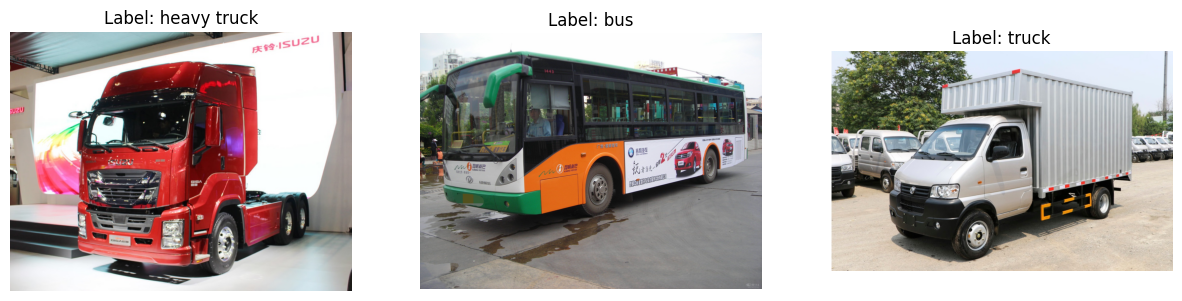

Displaying Sample Images from the Validation Dataset:


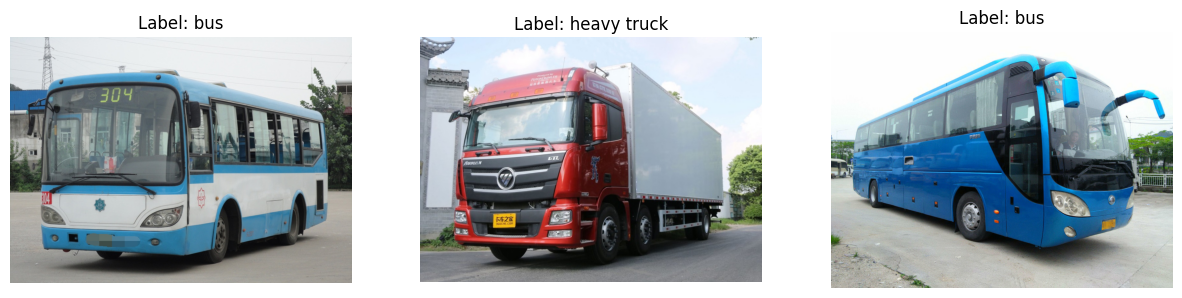

In [6]:
# Function to load image paths and assign labels based on folder names
def load_dataset_from_directory(directory):
    data = []
    for label, folder in enumerate(sorted(os.listdir(directory))):  # Sort to ensure consistent labeling
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
                    data.append({'path': img_path, 'label': folder})  # Use folder name as the label
    return pd.DataFrame(data)

# Function to create path-label list from DataFrame
def create_path_label_list(df):
    path_label_list = [(row['path'], row['label']) for _, row in df.iterrows()]
    return path_label_list

# Function to display images with labels
def display_images_with_labels(path_label_list, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, (path, label) in enumerate(path_label_list[:num_images]):
        try:
            img = Image.open(path)  # Load image using PIL
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')  # Hide axis

        except Exception as e:
            print(f"Error loading image {path}: {e}")
    
    plt.show()

train_data = load_dataset_from_directory(train_dir)
val_data = load_dataset_from_directory(val_dir)

# Shuffle the datasets
path_label_train = random.sample(create_path_label_list(train_data), len(train_data))
path_label_val = random.sample(create_path_label_list(val_data), len(val_data))

# Display some sample images from the training dataset
print("Displaying Sample Images from the Training Dataset:")
display_images_with_labels(path_label_train, num_images=3)

# Display some sample images from the validation dataset (optional)
print("Displaying Sample Images from the Validation Dataset:")
display_images_with_labels(path_label_val, num_images=3)


Displaying Original and Preprocessed Images from the Training Dataset:


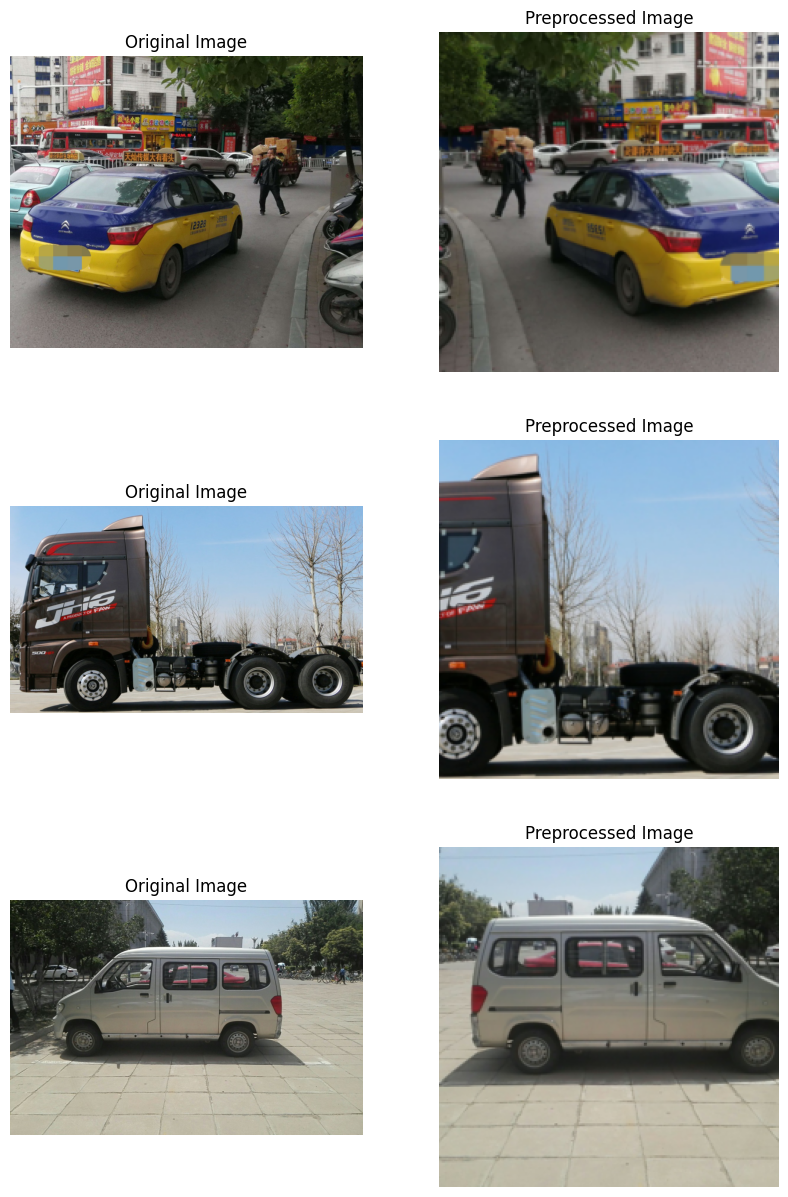

Displaying Original and Preprocessed Images from the Validation Dataset:


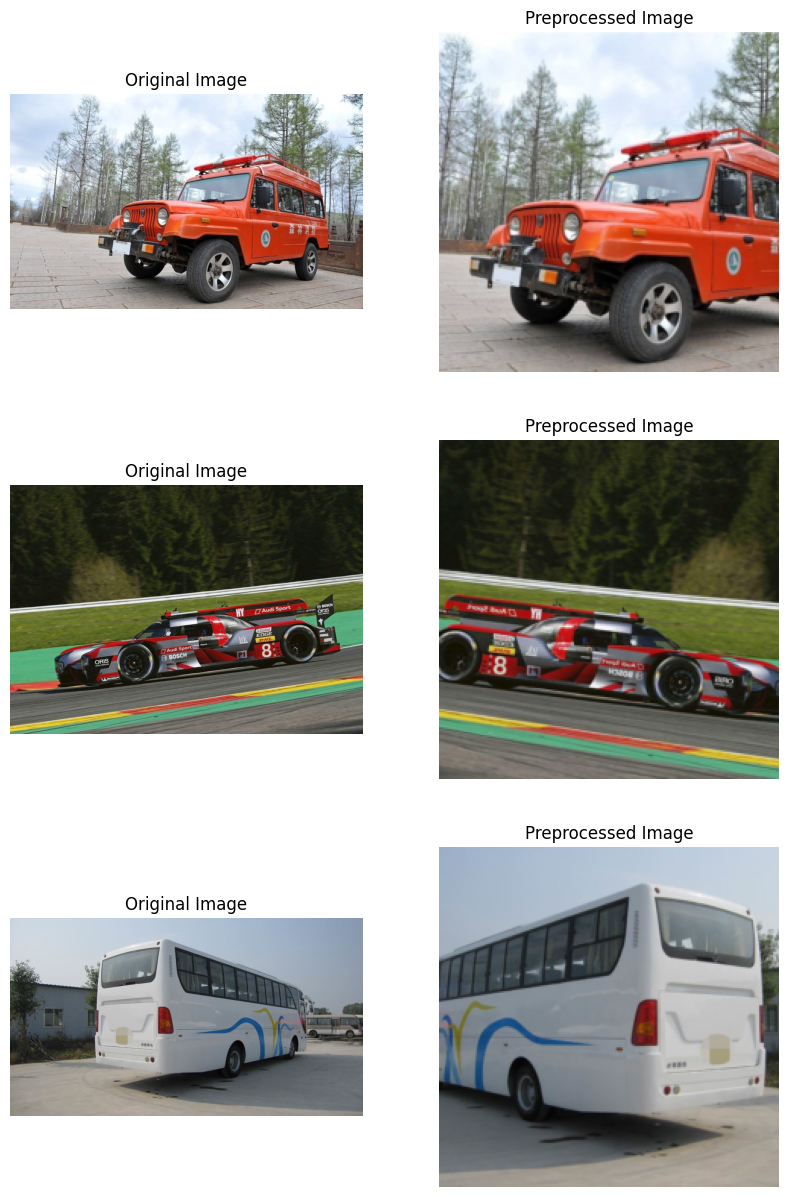

In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np

# Define the normalization values (used in your transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to denormalize the image for visualization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize each channel
    return tensor

# Function to display images before and after transformations
def display_images(image_paths, transform):
    num_images = len(image_paths)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i, original_image_path in enumerate(image_paths):
        original_img = Image.open(original_image_path).convert("RGB")  # Load original image

        # Apply the transformations
        tensor_img = transform(original_img)
        
        # Denormalize for display
        denorm_img = denormalize(tensor_img.clone(), mean, std)  # Clone to avoid modifying original tensor

        # Convert tensors to numpy arrays for display
        np_original = np.array(original_img)  # Original image as numpy array
        np_preprocessed = denorm_img.permute(1, 2, 0).numpy()  # Rearrange dimensions (C, H, W) -> (H, W, C)

        # Display original image
        axes[i, 0].imshow(np_original)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')  # Hide axis

        # Display preprocessed image
        axes[i, 1].imshow(np_preprocessed)
        axes[i, 1].set_title("Preprocessed Image")
        axes[i, 1].axis('off')  # Hide axis

    plt.show()

# Function to load dataset from directory
def load_dataset_from_directory(directory):
    data = []
    for label, folder in enumerate(sorted(os.listdir(directory))):  # Sort to ensure consistent labeling
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
                    data.append({'path': img_path, 'label': folder})  # Use folder name as the label
    return pd.DataFrame(data)

# Load train data
train_data = load_dataset_from_directory(train_dir)

# Shuffle the training dataset
path_label_train = random.sample(list(zip(train_data['path'], train_data['label'])), len(train_data))

# Select 3 random image paths from the training dataset
random_image_paths = [random.choice(path_label_train)[0] for _ in range(3)]  # Get the paths of 3 random images

# Display the original and preprocessed images
print("Displaying Original and Preprocessed Images from the Training Dataset:")
display_images(random_image_paths, transform)

# Optionally, do the same for the validation dataset if needed
# Load val data
val_data = load_dataset_from_directory(val_dir)

# Shuffle the validation dataset
path_label_val = random.sample(list(zip(val_data['path'], val_data['label'])), len(val_data))

# Select 3 random image paths from the validation dataset
random_val_image_paths = [random.choice(path_label_val)[0] for _ in range(3)]  # Get the paths of 3 random images

# Display the original and preprocessed images from validation dataset
print("Displaying Original and Preprocessed Images from the Validation Dataset:")
display_images(random_val_image_paths, transform)


Transfer Learning Using Resnet50

In [8]:
from torchvision import transforms, datasets
# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [9]:
EPOCHS = 20
LR = 0.1
BATCH = 64
IM_SIZE= 224
STEP = 5
GAMMA = 0.2
DECAY = 0.9

In [10]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match class count
num_classes = len(train_data['label'].unique())  # Number of output classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


c:\Users\user10\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user10\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=GAMMA, step_size=STEP)

In [12]:
from copy import deepcopy

best_model = deepcopy(model)
best_acc = 0.0

acc_train = []
acc_val = []
loss_train = []
loss_val = []

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for data, label in train_loader:
        optimizer.zero_grad()
        data, label = data.to(device), label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        train_loss += loss.item()
        
        _, preds = torch.max(output, 1)
        train_correct += (preds == label).sum().item()
        train_total += label.size(0)
        
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            val_loss += loss.item()
            
            _, preds = torch.max(output, 1)
            val_correct += (preds == label).sum().item()
            val_total += label.size(0)
            
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    # Track training and validation accuracy/loss
    acc_train.append(train_acc)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    
    # Track the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
    
    # Print progress for the current epoch
    print(f"Epoch {epoch}/{EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Step the scheduler
    scheduler.step()


Epoch 1/20, Train Loss: 0.0950, Train Acc: 0.3021, Val Loss: 0.0874, Val Acc: 0.3900
Epoch 2/20, Train Loss: 0.0272, Train Acc: 0.6700, Val Loss: 0.0393, Val Acc: 0.8200
Epoch 3/20, Train Loss: 0.0068, Train Acc: 0.8621, Val Loss: 0.0080, Val Acc: 0.8850
Epoch 4/20, Train Loss: 0.0051, Train Acc: 0.8950, Val Loss: 0.0119, Val Acc: 0.8650
Epoch 5/20, Train Loss: 0.0052, Train Acc: 0.8993, Val Loss: 0.0057, Val Acc: 0.9250
Epoch 6/20, Train Loss: 0.0030, Train Acc: 0.9464, Val Loss: 0.0053, Val Acc: 0.9100
Epoch 7/20, Train Loss: 0.0030, Train Acc: 0.9457, Val Loss: 0.0052, Val Acc: 0.9150
Epoch 8/20, Train Loss: 0.0028, Train Acc: 0.9543, Val Loss: 0.0051, Val Acc: 0.9150
Epoch 9/20, Train Loss: 0.0027, Train Acc: 0.9536, Val Loss: 0.0048, Val Acc: 0.9300
Epoch 10/20, Train Loss: 0.0027, Train Acc: 0.9550, Val Loss: 0.0047, Val Acc: 0.9250
Epoch 11/20, Train Loss: 0.0027, Train Acc: 0.9600, Val Loss: 0.0048, Val Acc: 0.9100
Epoch 12/20, Train Loss: 0.0025, Train Acc: 0.9636, Val Loss: 0

In [13]:
# Define your model saving directory
model_save_dir = 'C:/Dataset/vehicleClass/models/'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save the best model after training
model_save_path = os.path.join(model_save_dir, 'best_model.pth')
torch.save(best_model.state_dict(), model_save_path)

print(f"Best model saved at: {model_save_path}")

Best model saved at: C:/Dataset/vehicleClass/models/best_model.pth


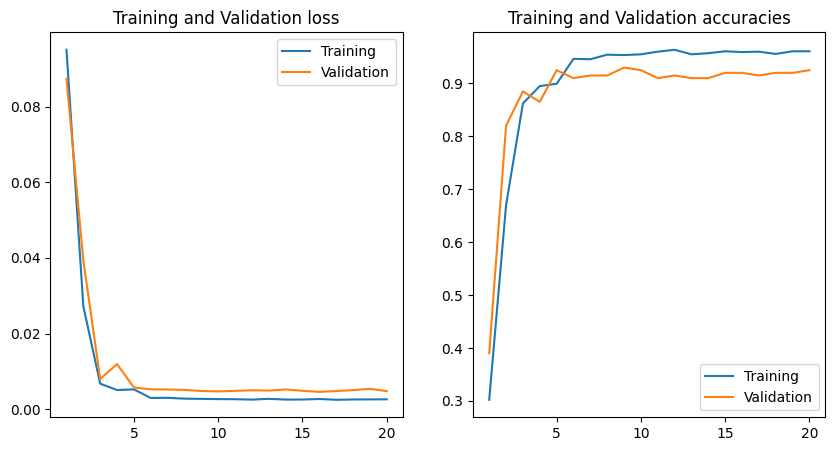

In [14]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(epochs, loss_train)
axes[0].plot(epochs, loss_val)
axes[0].set_title("Training and Validation loss")
axes[0].legend(["Training", "Validation"])
axes[1].plot(epochs, acc_train)
axes[1].plot(epochs, acc_val)
axes[1].set_title("Training and Validation accuracies")
axes[1].legend(["Training", "Validation"])
plt.show()

C:\Users\user10\AppData\Local\Temp\ipykernel_13796\886546655.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


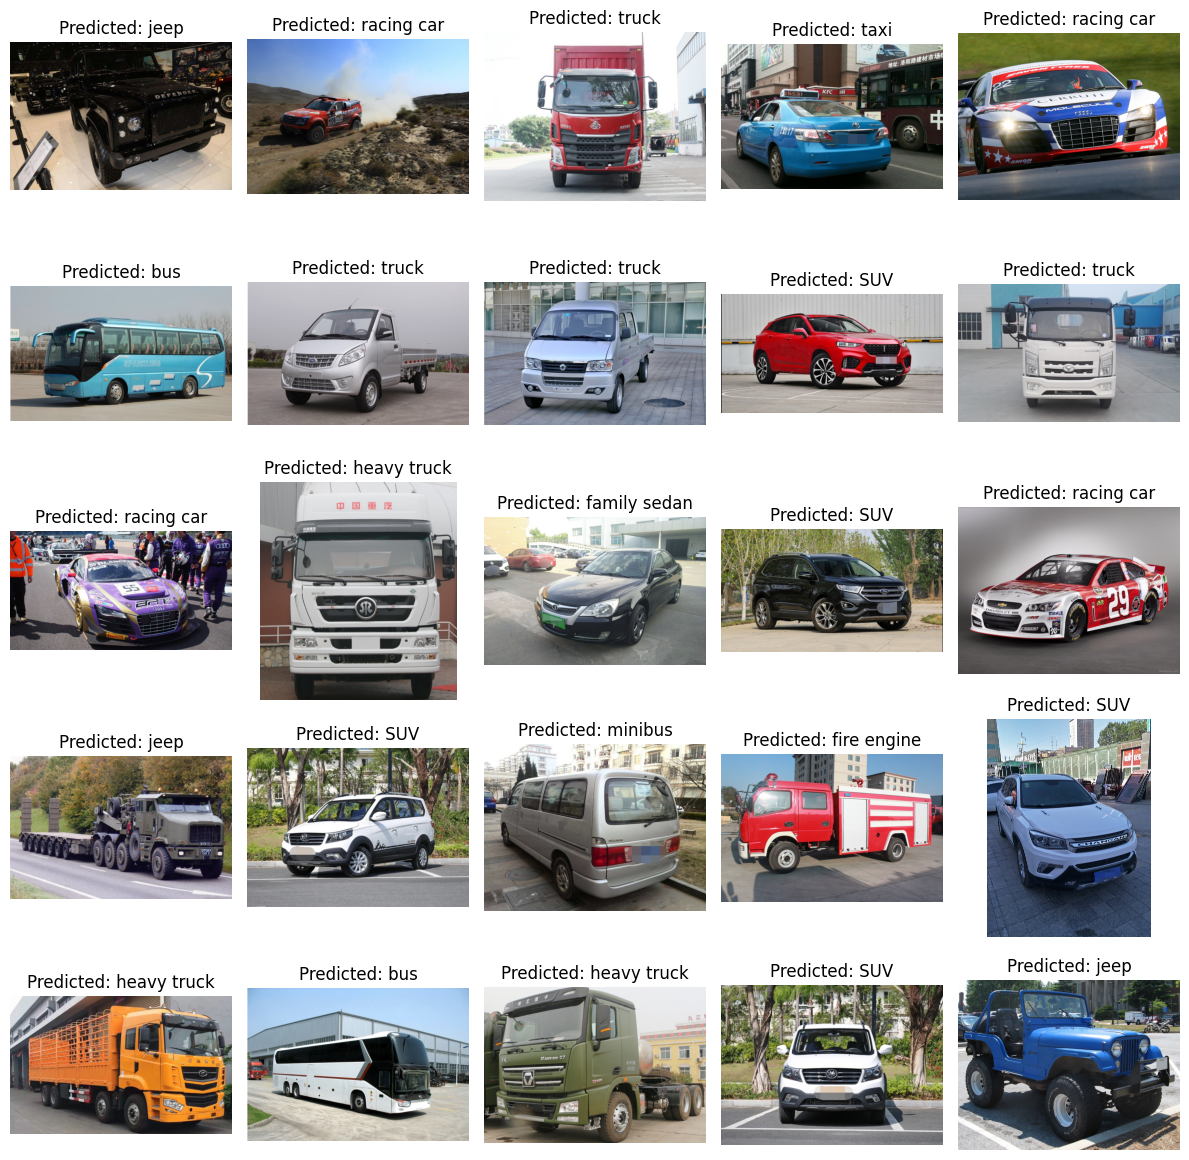

In [17]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define test data directory
test_dir = 'C:/Dataset/vehicleClass/test/'

# Load the best_model (if saved)
best_model_path = 'C:/Dataset/vehicleClass/models/best_model.pth'  # Re-instantiate your model
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# Define the transform (same as used for training)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# List all images in the test directory
test_image_paths = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) 
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Prepare to store predictions and images
predicted_labels = []

# Make predictions on the test dataset
for img_path in test_image_paths:
    # Load and transform the image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Make prediction
    with torch.no_grad():
        output = best_model(img_tensor)
        _, pred = torch.max(output, 1)
        predicted_labels.append(class_names[pred.item()])  # Store the predicted class name

# Display images with predicted labels
index = 0
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))

for i in range(5):
    for j in range(5):
        if index >= len(test_image_paths):
            break
        im = Image.open(test_image_paths[index])  # Load the image using its path
        axes[i][j].imshow(im)
        axes[i][j].set_title(f"Predicted: {predicted_labels[index]}")
        axes[i][j].axis('off')
        index += 1

plt.tight_layout()
plt.show()


Old

In [10]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

# Create DataLoaders from your preprocessed data
train_loader = DataLoader(
    datasets.ImageFolder(train_dir, transform=transform),
    batch_size=32, shuffle=True
)
val_loader = DataLoader(
    datasets.ImageFolder(val_dir, transform=transform),
    batch_size=32
)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss, total_acc = 0, 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            acc = (preds == labels).sum().item() / len(labels)

            total_loss += loss.item()
            total_acc += acc

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {total_acc/len(train_loader)}")

    # Save the trained model
    save_path='model.pt'
    torch.save(model.state_dict(), save_path)  # Save model weights
    print(f'Model saved to {save_path}')
    


In [ ]:
# Call the training function
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


In [ ]:

model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define the transformation (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size of your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load your trained model
model = models.resnet50(pretrained=False)  # Load the model without pretrained weights
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the final layer
model.load_state_dict(torch.load('model.pt'))  # Load trained weights
model.eval()  # Set the model to evaluation mode

# Function to make predictions for images in a single folder
def predict_from_folder(model, folder_path):
    predictions = []
    file_names = []

    with torch.no_grad():  # Disable gradient calculation
        for file_name in os.listdir(folder_path):
            if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Check for image files
                img_path = os.path.join(folder_path, file_name)  # Construct the full path
                image = Image.open(img_path)  # Open the image
                image = transform(image).unsqueeze(0)  # Apply transformation and add batch dimension
                
                image = image.to(device)  # Move image to the GPU if available
                output = model(image)  # Get model predictions
                _, pred = torch.max(output, 1)  # Get the predicted class

                predictions.append(pred.item())  # Store the predicted class index
                file_names.append(file_name)  # Store the filename for reference

    return file_names, predictions

# Use the function to make predictions
file_names, predictions = predict_from_folder(model, test_dir)

# Display the predictions
for file_name, pred in zip(file_names, predictions):
    print(f"File: {file_name}, Predicted Class: {pred}")


In [12]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

# Fit model

In [ ]:
dataset = ImageDataset(path_label)
dataset.setup() 
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader

datamodule = DataModule()
datamodule.setup() 
model = ConvolutionalNetwork()

trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, datamodule)
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

In [ ]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

# Predict Val as Test 

In [ ]:
tdataset = ImageDataset(tpath_label)
tdataset.setup(stage='Test') 
test_dataloader = tdataset.test_dataloader

datamodule = DataModule()
datamodule.setup(stage='Test') 
test_loader = datamodule.test_dataloader()

trainer.test(dataloaders=test_loader)

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
ty_true=[]
ty_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ty_true.append(test_labels[i].item())
            ty_pred.append(pred[i].item())

print(classification_report(ty_true,ty_pred,target_names=class_names,digits=4))